In [16]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
from time import sleep
from ta.volume import MFIIndicator 
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator, StochasticOscillator
from ta.trend import MACD, CCIIndicator
from ta.volatility import BollingerBands
import warnings
warnings.filterwarnings('ignore')
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [17]:
# Low-pass filter dùng cho lọc nhiễu data
from scipy.signal import butter,lfilter 
def lowpass_filter(signal, ratio):
    b, a = butter(1, ratio, btype='low', analog=False)
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

In [18]:
data = pd.read_csv('.\data1mins.csv')
data

Loading ITables v2.5.2 from the internet... (need help?)


In [19]:
data.Date = pd.to_datetime(data.Date, errors='coerce')
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index() 

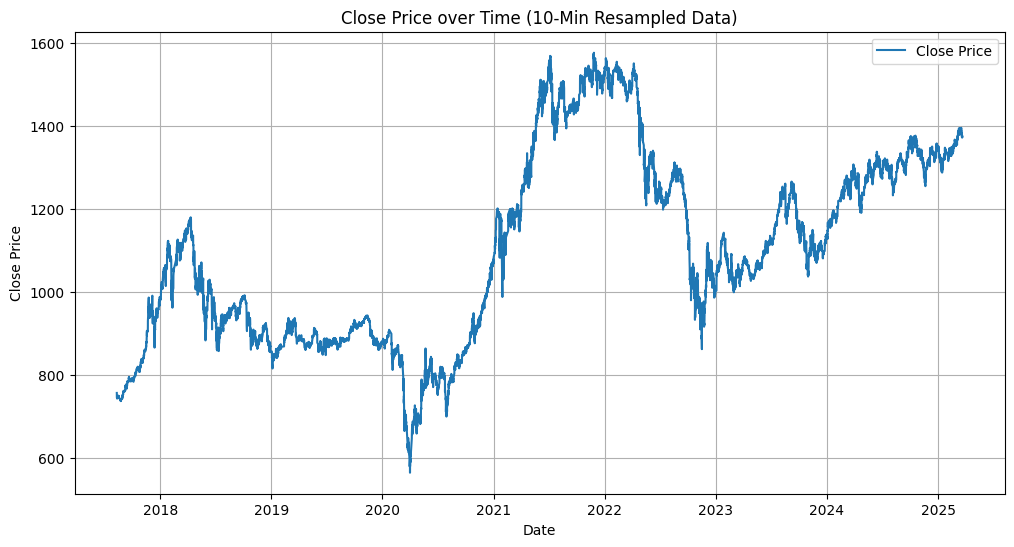

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price over Time (10-Min Resampled Data)")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
#path to expiration_date file
df = pd.read_csv('expiration_date.csv') 
df['Date'] = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))

In [22]:
# Nguyên tắc xây dựng mô hình
# 1. 1 chỉ báo xu hướng + 1 chỉ báo momentum + 1 chỉ báo biến động/volume là đủ → tránh overfitting.
# 2. Thêm Price Action để lọc tín hiệu cuối cùng (ví dụ: chỉ vào lệnh khi có Pin Bar/Engulfing tại hỗ trợ/kháng cự).
# 3. Backtest & Optimization: mỗi thị trường (stock, crypto, forex) và mỗi timeframe sẽ cần tinh chỉnh khác nhau.
# 4. Risk Management: ATR để set SL, fixed RR (risk/reward ratio) để chốt lời.

In [ ]:
import datetime
import numpy as np
import pandas as pd
from ta.momentum import StochasticOscillator
from ta.trend import EMAIndicator

def alpha(data, params, expiration_date=set(), use_close_filtered=False):
    """
    params gợi ý:
      w1: window %K (vd 14)
      w2: smooth_window %D (vd 3)
      ema: chu kỳ EMA filter (vd 100 hoặc 200; 0 = tắt filter)
      k_low: ngưỡng quá bán để vào (vd 20)
      k_high: ngưỡng quá mua để vào (vd 80)
      exit_low: ngưỡng thoát long (vd 75)
      exit_high: ngưỡng thoát short (vd 25)
    """
    data = data.copy()

    # (tuỳ chọn) lọc nhiễu giá đóng bằng lowpass của bạn
    if use_close_filtered and 'Close_filtered' in data.columns:
        close_for_osc = data['Close_filtered']
    else:
        close_for_osc = data['Close']

    # Tính Stochastic
    so = StochasticOscillator(
        high=data['High'],
        low=data['Low'],
        close=close_for_osc,
        window=params.get('w1', 14),
        smooth_window=params.get('w2', 3)
    )
    data['Stoch_K'] = so.stoch()
    data['Stoch_D'] = so.stoch_signal()

    # Trend filter (EMA) – đặt ema=0 để tắt
    ema_period = params.get('ema', 0)
    if ema_period and ema_period > 0:
        ema_val = EMAIndicator(close=data['Close'], window=ema_period).ema_indicator()
        data['trend_up'] = data['Close'] > ema_val
        data['trend_dn'] = data['Close'] < ema_val
    else:
        data['trend_up'] = True
        data['trend_dn'] = True

    # Ngưỡng
    k_low     = params.get('k_low', 20)   # vào long khi dưới k_low
    k_high    = params.get('k_high', 80)  # vào short khi trên k_high
    exit_low  = params.get('exit_low', 75)  # thoát long khi vượt lên vùng cao
    exit_high = params.get('exit_high', 25) # thoát short khi rơi xuống vùng thấp

    K = data['Stoch_K']
    D = data['Stoch_D']

    # Cờ giao cắt
    cross_up   = (K.shift(1) < D.shift(1)) & (K >= D)     # %K cắt lên %D
    cross_down = (K.shift(1) > D.shift(1)) & (K <= D)     # %K cắt xuống %D

    pos = 0
    position = []

    for i in range(len(data)):
        k = K.iat[i]
        d = D.iat[i]
        date_i = pd.to_datetime(data['Date'].iat[i])

        # ====== ENTRY RULES ======
        if pos == 0:
            # Long: giao cắt lên trong vùng quá bán + xu hướng tăng (nếu bật)
            if cross_up.iat[i] and (k < k_low) and bool(data['trend_up'].iat[i]):
                pos = 1
            # Short: giao cắt xuống trong vùng quá mua + xu hướng giảm (nếu bật)
            elif cross_down.iat[i] and (k > k_high) and bool(data['trend_dn'].iat[i]):
                pos = -1

        # ====== EXIT RULES ======
        elif pos == 1:
            # Thoát Long: giao cắt xuống hoặc K vượt lên exit_low (hysteresis 75)
            if cross_down.iat[i] or (k > exit_low):
                pos = 0
        elif pos == -1:
            # Thoát Short: giao cắt lên hoặc K xuống dưới exit_high (hysteresis 25)
            if cross_up.iat[i] or (k < exit_high):
                pos = 0

        # ====== TIME-BASED RULES ======
        # Cắt cuối ngày (14:25)
        if date_i.time() == datetime.time(14, 25):
            if pos == -1:
                pos = 0  # giữ tuỳ chọn như bạn chú thích
        # Đảo hạn (14:45)
        if date_i.time() == datetime.time(14, 45):
            if len(position) > 0 and date_i.date() in expiration_date:
                pos = 0

        position.append(pos)

    data['pos'] = position
    return data


In [ ]:
# # pip install optuna ta pandas numpy
# import optuna
# import numpy as np
# import pandas as pd

# # ==== Metric & backtest (gọn, không lookahead) ====
# def compute_metrics(df, price_col='Close', pos_col='pos',
#                     slip_bps=1.0, fee_bps=1.0):
#     """
#     - slip_bps, fee_bps: chi phí mỗi lần đổi vị thế (basis points, 1 bps = 0.01%)
#     - Trả về Sharpe (annualized ~252 ngày), MDD, #trades
#     """
#     df = df.copy()

#     # Lợi nhuận theo % mỗi bar
#     ret = df[price_col].pct_change().fillna(0.0)
#     pos = df[pos_col].fillna(0.0)

#     # Khớp lệnh bar sau để tránh lookahead trong P&L
#     pos_shift = pos.shift(1).fillna(0.0)
#     strat_ret = ret * pos_shift

#     # Phí/ trượt giá khi thay đổi vị thế (đơn giản: khi |Δpos| > 0)
#     delta_pos = pos.diff().abs().fillna(0.0)
#     trade_cost = (slip_bps + fee_bps) / 10000.0
#     cost = delta_pos * trade_cost
#     # Trừ chi phí vào lợi nhuận
#     strat_ret = strat_ret - cost

#     # Gộp theo ngày để tính Sharpe ngày
#     if 'Date' in df.columns:
#         day = pd.to_datetime(df['Date']).dt.date
#         daily_ret = strat_ret.groupby(day).sum()
#     else:
#         daily_ret = strat_ret

#     mean = daily_ret.mean()
#     std  = daily_ret.std(ddof=1)
#     sharpe = 0.0 if std == 0 else (mean / std) * np.sqrt(252)

#     # MDD
#     eq = (1 + daily_ret).cumprod()
#     dd = (eq.cummax() - eq) / eq.cummax()
#     mdd = dd.max() if len(dd) else 0.0

#     # Số lần đổi vị thế (đếm “giao dịch”)
#     trades = int((delta_pos > 0).sum())

#     return {'sharpe': float(sharpe), 'mdd': float(mdd), 'trades': trades}

# # ==== Objective cho Optuna ====
# def make_objective(data, expiration_dates=None, base_params=None):
#     """
#     - data: DataFrame đã resample 10Min & reset_index (như bạn làm)
#     - alpha: dùng phiên bản bạn dán (có ATR/RSI/MFI…)
#     - base_params: bộ mặc định; sẽ được cập nhật bởi trial
#     """
#     base_params = dict(base_params or {})

#     def objective(trial: optuna.Trial):
#         # --- Search space ---
#         # MFI thresholds
#         t2 = trial.suggest_float('t2', 5, 40)    # into short: MFI < t2
#         t3 = trial.suggest_float('t3', 60, 95)   # into long : MFI > t3
#         t4 = trial.suggest_float('t4', 40, 85)   # exit short: MFI > t4
#         t5 = trial.suggest_float('t5', 15, 60)   # exit long : MFI < t5
#         # Cửa sổ chỉ báo
#         w1 = trial.suggest_int('w1', 10, 30)
        

#         # --- Ràng buộc logic mềm ---
#         penalty = 0.0
#         if not (t2 < t4):
#             penalty += (t2 - t4 + 1e-6)
#         if not (t5 < t3):
#             penalty += (t5 - t3 + 1e-6)

#         # --- Lắp tham số & chạy alpha ---
#         params = {
#             # giữ t1 nếu bạn dùng lowpass_filter ở nơi khác; không tối ưu ở đây
#             't1': base_params.get('t1', 0.75),
#             'w1': w1,
#             't2': t2, 't3': t3, 't4': t4, 't5': t5,
#         }

#         df_pos = alpha(data, params)

#         # --- Tính metric ---
#         metrics = compute_metrics(df_pos, slip_bps=1.0, fee_bps=1.0)
#         score = metrics['sharpe']

#         # phạt nếu ràng buộc sai
#         if penalty > 0:
#             score -= 5.0 * penalty  # hệ số phạt — có thể tăng

#         # (tùy chọn) phạt nếu quá ít giao dịch
#         if metrics['trades'] < 5:
#             score -= 0.5

#         # (tùy chọn) risk-aware
#         # score -= 0.5 * metrics['mdd']

#         trial.report(score, step=0)
#         return score

#     return objective

# # ==== Chạy study ====
# sampler = optuna.samplers.TPESampler(seed=42, multivariate=True, group=True)
# pruner  = optuna.pruners.MedianPruner(n_warmup_steps=10)

# study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
# # base_params: lấy đúng bộ bạn đang dùng làm mặc định
# base_params = {'t1': 0.75, 't2': 13, 't3': 81, 't4': 59, 't5': 37, 'w1': 14}
# study.optimize(make_objective(data, expiration_dates=None, base_params=base_params),
#                n_trials=200, show_progress_bar=True)

# print("Best Sharpe:", study.best_value)
# print("Best params:", study.best_params)

# # Backtest với bộ tốt nhất
# best_params = base_params.copy()
# best_params.update(study.best_params)
# df_best = alpha(data, best_params)
# final = compute_metrics(df_best)
# print("Final metrics:", final)

In [24]:
params = {'t1': 0.75, 't2': 13, 't3': 81, 't4': 59, 't5': 37, 'w1': 14, 'w2': 14}
ds = alpha(data, params)
ds

Loading ITables v2.5.2 from the internet... (need help?)


Margin: -1.95
MDD: 541.0 (34.48%)

   Total trading quantity: 1239
         Profit per trade: -0.91
             Total Profit: -519.1
         Profit after fee: -1133.6
 Trading quantity per day: 0.65
 Profit per day after fee: -0.6
                   Return: -0.09
          Profit per year: -148.78
                  HitRate: 0.29
          HitRate per day: 0.18


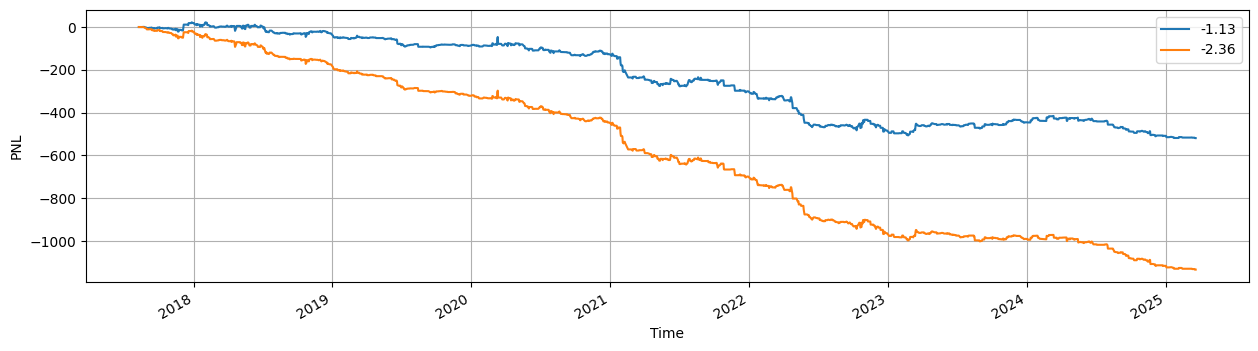

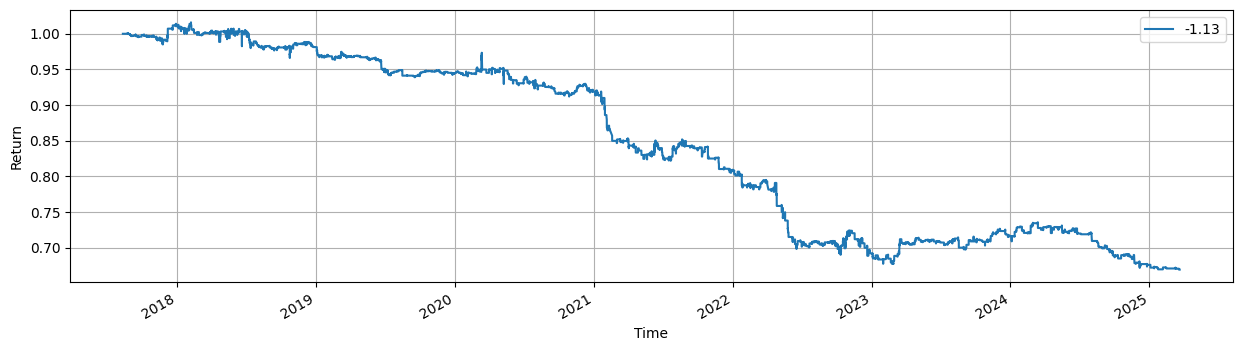

In [25]:
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()

In [26]:
ds.pos

Loading ITables v2.5.2 from the internet... (need help?)


In [27]:
pnl

Loading ITables v2.5.2 from the internet... (need help?)
